### Preliminary imports

In [1]:
import numpy as np
import os
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

### Importing scikit learn modules

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [3]:
cwd = os.path.dirname(os.getcwd())
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
doc_dir = os.path.join(os.path.dirname(os.getcwd()), 'docs')

###### Loading sfnc_pairs.mat

In [4]:
sfnc_pairs = sio.loadmat(os.path.join(data_dir,'sfnc_pairs.mat'))
sfnc_corr_pairs = sfnc_pairs['fnc_corrs']

###### Plotting the correlation matrix

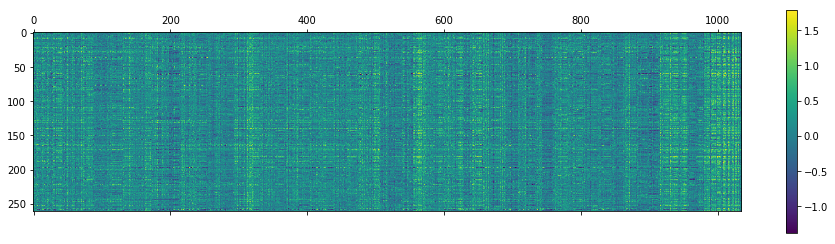

In [5]:
plt.matshow(sfnc_corr_pairs);
plt.colorbar()
plt.show()

###### Feature Selection

In [6]:
demographics = pd.read_excel(os.path.join(data_dir, '20160420_vcalhoun_rest_demography_cag_info_new.xls'))
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 35 columns):
external_id                  261 non-null object
visit                        261 non-null int64
visit_date                   261 non-null int64
visit_age                    261 non-null float64
scanid                       261 non-null int64
scan_date                    261 non-null int64
age_at_scan                  261 non-null float64
project                      261 non-null object
scanner                      261 non-null object
scanner_id                   261 non-null int64
field_strength               261 non-null int64
gender                       261 non-null object
gender_id                    261 non-null int64
race                         261 non-null int64
ethnicity                    261 non-null int64
education_years_max          256 non-null float64
cap_e_score                  183 non-null float64
cap_e_group                  261 non-null object
cap_d_score       

In [7]:
demographics.cap_d_group_id2.value_counts()

1    183
0     78
Name: cap_d_group_id2, dtype: int64

In [8]:
X = sfnc_corr_pairs
y = demographics.cap_d_group_id2

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1)

### PCA of the training data

In [10]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[0.14688882 0.20476082 0.25805768 0.29254787 0.31974751 0.34275781
 0.36346198 0.38212706 0.39971148 0.41599822 0.43163259 0.44678795
 0.46060927 0.47386978 0.48624446 0.49840061 0.50992002 0.52089714
 0.53159351 0.54134717 0.5507203  0.56001959 0.5688491  0.57742995
 0.58569049 0.59389217 0.60174116 0.60949073 0.61701462 0.62444256
 0.63164813 0.63859313 0.64537134 0.65205617 0.65867612 0.66511693
 0.67123088 0.67710145 0.68282063 0.68827995 0.69369056 0.69897741
 0.70417448 0.70927236 0.71435232 0.71930803 0.72398522 0.72861298
 0.73311777 0.73757258 0.74196081 0.7463178  0.75061431 0.75480275
 0.75893942 0.76300776 0.7670144  0.77096684 0.77473717 0.77844414
 0.78211065 0.78574758 0.78932038 0.7928044  0.79618211 0.79946493
 0.80272632 0.80596106 0.80913272 0.81223949 0.81531447 0.81834717
 0.82134116 0.82433243 0.82723765 0.830099   0.83294948 0.83574281
 0.83844474 0.84111284 0.84373597 0.84629648 0.84883479 0.85132272
 0.8537705  0.85618727 0.85855915 0.86089263 0.86322038 0.8655

In [12]:
var_exp.shape

(208,)

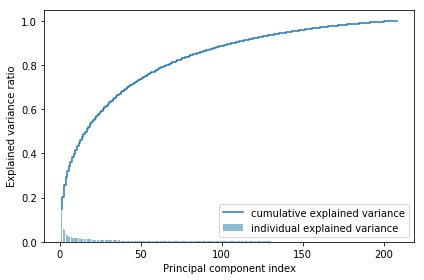

In [13]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 209), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 209), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [14]:
cum_var_exp[149]

0.9597736936125103

In [15]:
num_components = X_train.shape[0]
print(num_components)

208


### Fitting a simple logistic regression model

In [16]:
pipe_lr = make_pipeline(PCA(n_components=num_components),
                        LogisticRegression(solver='lbfgs'))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
print('F1-Score: %.3f' % f1_score(y_test, y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under ROC Curve: %.3f' % roc_auc)

Test Accuracy: 0.623
F1-Score: 0.744
Area under ROC Curve: 0.517


### Fitting a linear SVM

In [17]:
pipe_svc = make_pipeline(PCA(n_components=num_components),
                        LinearSVC())

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
print('Test Accuracy: %.3f' % pipe_svc.score(X_test, y_test))
print('F1-Score: %.3f' % f1_score(y_test, y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under ROC Curve: %.3f' % roc_auc)

Test Accuracy: 0.642
F1-Score: 0.753
Area under ROC Curve: 0.548


### Fitting a RBF SVM

In [22]:
pipe_rbf = make_pipeline(PCA(n_components=num_components),
                        SVC(gamma='auto'))

pipe_rbf.fit(X_train, y_train)
y_pred = pipe_rbf.predict(X_test)
print('Test Accuracy: %.3f' % pipe_rbf.score(X_test, y_test))
print('F1-Score: %.3f' % f1_score(y_test, y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under ROC Curve: %.3f' % roc_auc)

Test Accuracy: 0.698
F1-Score: 0.822
Area under ROC Curve: 0.500


### Fitting a Decision Tree

In [19]:
pipe_dt = Pipeline([('pca', PCA(n_components=num_components)),
                         ('dt', DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None))])

pipe_dt.fit(X_train, y_train)
y_pred = pipe_dt.predict(X_test)
print('Test Accuracy: %.3f' % pipe_dt.score(X_test, y_test))
print('F1-Score: %.3f' % f1_score(y_test, y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under ROC Curve: %.3f' % roc_auc)

Test Accuracy: 0.604
F1-Score: 0.741
Area under ROC Curve: 0.468


### Fitting a kNN

In [20]:
pipe_knn = Pipeline([('pca', PCA(n_components=num_components)),
                         ('knn', KNeighborsClassifier())])

pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
print('Test Accuracy: %.3f' % pipe_knn.score(X_test, y_test))
print('F1-Score: %.3f' % f1_score(y_test, y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under ROC Curve: %.3f' % roc_auc)

Test Accuracy: 0.604
F1-Score: 0.741
Area under ROC Curve: 0.468


### Fitting Random Forests

In [21]:
pipe_rf = Pipeline([('pca', PCA(n_components=num_components)),
                         ('rf', RandomForestClassifier())])

pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
print('Test Accuracy: %.3f' % pipe_rf.score(X_test, y_test))
print('F1-Score: %.3f' % f1_score(y_test, y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under ROC Curve: %.3f' % roc_auc)

Test Accuracy: 0.623
F1-Score: 0.767
Area under ROC Curve: 0.446


/export/mialab/users/mialab_softwares/.anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
